In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Define a custom dataset for plant leaf images
# Make sure to organize your dataset into folders representing each class
# For example: train/Class1, train/Class2, test/Class1, test/Class2, etc.
dataset_root = "path/to/your/dataset"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = ImageFolder(root=dataset_root, transform=transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# Standardize the data
scaler = StandardScaler()
train_data = [scaler.fit_transform(img.numpy().flatten().reshape(1, -1)) for img, _ in train_set]
train_data = torch.tensor(np.concatenate(train_data), dtype=torch.float32)

# Use k-means to find the centers of the radial basis functions
num_centers = 50
kmeans = KMeans(n_clusters=num_centers, random_state=42)
kmeans.fit(train_data)
centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

# Define the Gaussian Radial Basis Function (RBF) layer
class RBFLayer(nn.Module):
    def __init__(self, num_centers, input_dim):
        super(RBFLayer, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))
        self.sigma = nn.Parameter(torch.ones(num_centers))

    def forward(self, x):
        # Flatten the input image
        x = x.view(x.size(0), -1)
        
        # Calculate the radial basis functions with Gaussian RBF formula
        dist = torch.cdist(x, self.centers)
        rbf = torch.exp(-dist.pow(2) / (2 * self.sigma.pow(2)))
        return rbf

# Define the RBF Network
class RBFNetwork(nn.Module):
    def __init__(self, input_dim, num_centers, output_dim):
        super(RBFNetwork, self).__init__()
        self.rbf_layer = RBFLayer(num_centers, input_dim)
        self.linear_layer = nn.Linear(num_centers, output_dim)

    def forward(self, x):
        rbf_output = self.rbf_layer(x)
        output = self.linear_layer(rbf_output)
        return output

# Instantiate the RBF Network
input_dim = train_data.shape[1]
output_dim = len(dataset.classes)
rbf_network = RBFNetwork(input_dim, num_centers, output_dim)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rbf_network.parameters(), lr=0.001)

# DataLoader for training set
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

# Training the RBF Network
num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = rbf_network(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# DataLoader for test set
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Make predictions on test data
rbf_network.eval()
all_labels, all_predictions = [], []

with torch.no_grad():
    for images, labels in test_loader:
        output_test = rbf_network.rbf_layer(images)
        output_test = rbf_network.linear_layer(output_test)
        _, predicted_labels = torch.max(output_test, 1)

        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted_labels.numpy())

# Calculate accuracy on test data
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Test Accuracy: {accuracy:.4f}')

In [3]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader,Dataset,random_split
from torchvision import transforms
from sklearn.cluster import KMeans
import numpy as np

In [4]:
class CustomDataset(Dataset):
    def __init__(self,root_dir,transform=None):
        self.root_dir=root_dir
        self.transform=transform
        self.file_paths=[]
        self.class_names=sorted(os.listdir(root_dir))

        for class_name in self.class_names:
            class_path=os.path.join(self.root_dir,class_name)
            files=[os.path.join(class_path,file) for file in os.listdir(class_path)]
            self.file_paths.extend(files)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self,idx):
        img_path=self.file_paths[idx]
        image=Image.open(img_path)

        if self.transform:
            image=self.transform(image)

        class_name=os.path.basename(os.path.dirname(img_path))
        label_idx=torch.tensor(self.class_names.index(class_name),dtype=torch.long)

        return image,label_idx,class_name

In [5]:
transform=transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])

dataset=CustomDataset(root_dir="D:\SEM-6\DL-LAB\Medicinal_plants_DS",transform=transform)

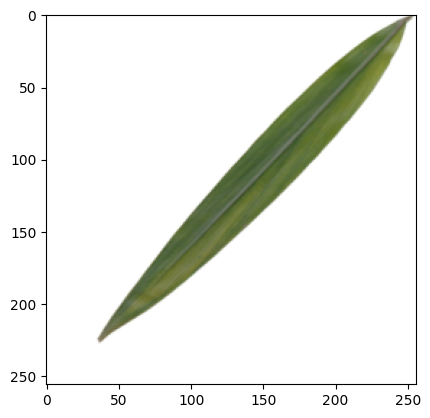

In [6]:
plt.imshow(dataset[8][0].permute(1,2,0))

In [7]:
train_size=int(0.8*len(dataset))
val_size=(len(dataset)-train_size)//3
test_size=len(dataset)-train_size-val_size
print("Training size : ",train_size)
print("Test size :",test_size)
print("Validation size ",val_size)

Training size :  1947
Test size : 325
Validation size  162


In [8]:
train_dataset,val_dataset,test_dataset=random_split(dataset,[train_size,val_size,test_size])
batch_size=64
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [15]:
print(len(train_dataset))
print(len(dataset))

1947
2434


PERFORMING KMEANS

In [16]:
import random
random_index=[random.randint(0,len(dataset)-1) for i in range(200)]
print(random_index)

subsetDS=torch.utils.data.Subset(dataset,random_index)
subsetLoader=DataLoader(subsetDS,batch_size=batch_size,shuffle=True)

[949, 884, 1756, 1058, 1002, 2180, 2129, 838, 1281, 1927, 1451, 429, 2174, 1118, 363, 2374, 2163, 2268, 1041, 1584, 529, 2123, 446, 279, 352, 1588, 1779, 1844, 856, 2312, 218, 74, 1343, 216, 813, 2074, 480, 811, 447, 950, 501, 1000, 1492, 2231, 620, 257, 1222, 383, 122, 1942, 1418, 1205, 1315, 2016, 1515, 1573, 1409, 973, 2039, 499, 101, 450, 890, 2343, 1295, 539, 2339, 170, 1243, 426, 1961, 2409, 164, 1996, 1693, 1841, 62, 1260, 1629, 934, 1838, 518, 314, 911, 1598, 1928, 74, 1011, 2252, 1558, 1488, 1375, 1629, 1591, 1648, 486, 1961, 624, 20, 1278, 2128, 145, 72, 1981, 640, 1304, 71, 690, 563, 302, 1644, 2269, 1182, 1226, 45, 1639, 763, 1934, 1704, 1111, 1159, 506, 193, 1417, 330, 2039, 1862, 227, 693, 2021, 112, 736, 105, 2288, 1971, 697, 1231, 126, 2347, 1105, 2082, 1303, 579, 791, 1351, 426, 1895, 2423, 1386, 270, 1687, 147, 2123, 1711, 1487, 135, 2345, 908, 498, 2128, 1422, 1167, 339, 201, 1002, 318, 126, 1605, 1801, 1266, 1029, 793, 34, 930, 1424, 1078, 1377, 739, 429, 2315, 899,

In [17]:
flatten_img=[]
for img,labels,names in subsetLoader:
    print(img.size())
    flatten_img.append(img.view(img.size(0),-1))

torch.Size([64, 3, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([64, 3, 256, 256])
torch.Size([8, 3, 256, 256])


In [22]:
print(len(flatten_img))
print(flatten_img)

4
[tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]), tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]), tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]), tensor([[0.8039, 0.8039, 0.8078,  ..., 0.9412, 0.9412, 0.9373],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.

In [19]:
flat_images=torch.cat(flatten_img,dim=0)

In [21]:
print(len(flat_images))

200


In [23]:
flat_images.numpy()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [24]:
#APPLYING KMEANS

ml=KMeans(n_clusters=15,random_state=42)
ml.fit(flat_images.numpy())

c:\Users\MAAL SUBIKSHA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=15, random_state=42)

In [29]:
centers=torch.from_numpy(ml.cluster_centers_).float()
print(centers)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [0.5294, 0.5333, 0.5373,  ..., 0.3294, 0.3216, 0.3176],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])


In [31]:
class RBFLayer(nn.Module):
    def __init__(self,input_dim,output_dim,centers=None):
        super(RBFLayer,self).__init__()
        if centers is not None:
            self.centers=nn.Parameter(centers)
        else:
            self.centers=nn.Parameter(torch.Tensor(output_dim,input_dim))
        self.sigma=0.5

    def forward(self,x):
        dist=torch.sqrt(torch.sum((x.unsqueeze(1)-self.centers.unsqueeze(0))**2,dim=2))
        return torch.exp(-dist**2/(2*self.sigma**2))

In [32]:
class RBFNetwork(nn.Module):
    def __init__(self,input_size,output_size,num_centers,centers=None):
        super(RBFNetwork,self).__init__()
        self.rbf_layer=RBFLayer(input_size,num_centers,centers)
        self.linear=nn.Linear(num_centers,output_size)

    def forward(self,x):
        x=x.view(x.size(0),-1)
        x=self.rbf_layer(x)
        x=self.linear(x)
        return x

In [34]:
input_size=256*256
print(dataset.class_names)
output_size=len(dataset.class_names)

model=RBFNetwork(input_size,output_size,15,centers)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.01)



['Alpinia Galanga', 'Amaranthus Viridis', 'Artocarpus Heterophyllus', 'Azadirachta Indica', 'Basella Alba', 'Brassica Juncea', 'Carissa Carandas', 'Citrus Limon', 'Ficus Auriculata', 'Ficus Religiosa', 'Hibiscus Rosa-sinensis', 'Jasminum', 'Mangifera Indica', 'Mentha', 'Moringa Oleifera', 'Muntingia Calabura', 'Murraya Koenigii', 'Nerium Oleander', 'Nyctanthes Arbor-tristis', 'Ocimum Tenuiflorum']


In [35]:
epoch=3
train_losses=[]
val_losses=[]

for i in range(epoch):
    model.train()
    for inputs,labels,_ in train_loader:
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

    val_loss=0.0
    correct=0
    total=0
    model.eval()
    with torch.no_grad():
        for inputs,labels,_ in val_loader:
            outputs=model(inputs)
            val_loss+=criterion(outputs,labels).item()

            j,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()

    train_losses.append(loss.item())
    val_losses.append(val_loss/len(val_loader))

    print("After epoch",i+1,"Validation Loss:",val_loss/len(val_loader),"Accuracy:",100*correct/total)

After epoch 1 Validation Loss: 3.0299440224965415 Accuracy: 4.938271604938271
After epoch 2 Validation Loss: 3.028028964996338 Accuracy: 4.938271604938271
After epoch 3 Validation Loss: 3.0261784394582114 Accuracy: 4.938271604938271


In [36]:
model.eval()
test_loss=0.0
correct=0
total=0

with torch.no_grad():
    for inputs,labels,_ in test_loader:
        outputs=model(inputs)
        test_loss+=criterion(outputs,labels).item()

        j,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

print("Testing Loss:",test_loss/len(test_loader),"Accuracy:",100*correct/total)

Testing Loss: 3.0013601779937744 Accuracy: 6.461538461538462


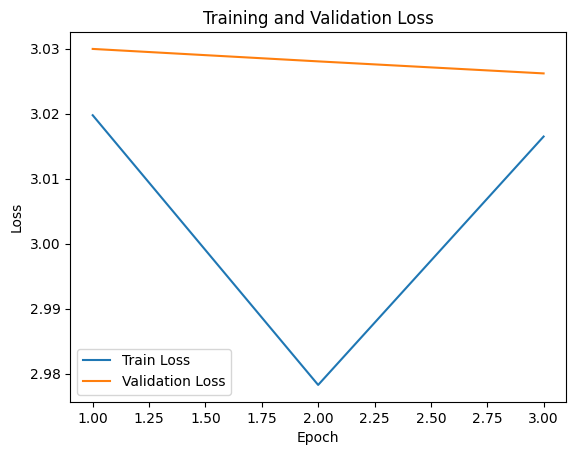

In [37]:
plt.plot(range(1,epoch+1),train_losses,label='Train Loss')
plt.plot(range(1,epoch+1),val_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()